In [1]:
import os
import shutil
import random as rd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

## Dataset

In [2]:
healthy = os.listdir('POTATOES/healthy')
damaged = os.listdir('POTATOES/damaged')

rd.shuffle(healthy)
rd.shuffle(damaged)

print('Total healthy images:', len(healthy))
print('Total damaged images:', len(damaged))

Total healthy images: 409
Total damaged images: 840


In [3]:
train_size = 350
test_size = 50
validation_size = 9

dataset = {
    'train': {
        'healthy': healthy[:train_size],
        'damaged': damaged[:train_size],
    },
    'test': {
        'healthy': healthy[train_size:train_size+test_size],
        'damaged': damaged[train_size:train_size+test_size],
    },
    'validation': {
        'healthy': healthy[train_size+test_size:train_size+test_size+validation_size],
        'damaged': damaged[train_size+test_size:train_size+test_size+validation_size],
    },
}

In [4]:
# Define root directory
src_dir = './POTATOES'
dst_dir = './dataset'


# Empry directory
if os.path.exists(dst_dir): shutil.rmtree(dst_dir)

for group in ['train', 'test', 'validation']:
    for label in ['healthy', 'damaged']:
        # Generate paths
        os.makedirs(dst_dir + '/' + group + '/' + label)
        # Create new dataset
        for filename in dataset[group][label]:
            shutil.copy(
                src_dir + '/' + label + '/' + filename,
                dst_dir + '/' + group + '/' + label + '/' + filename,
            )

In [5]:
# Training set with data augmentation
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   # shear_range = 0.2,
                                   # zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

# Test set just rescaled
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

In [6]:
batch_size = 10
# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(directory=dst_dir + '/train',
                                                    class_mode='binary',
                                                    batch_size=batch_size,
                                                    target_size=(250, 250))

# Flow testing images in batches of 10 using test_datagen generator
test_generator =  train_datagen.flow_from_directory(directory=dst_dir + '/test',
                                                    class_mode  = 'binary',
                                                    batch_size=batch_size,
                                                    target_size = (250, 250))

Found 700 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## Model

In [18]:
model = tf.keras.models.Sequential([
    # Conv layers
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(250,250,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten layer
    tf.keras.layers.Flatten(),
    # Fully connected layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # Output neuron
    tf.keras.layers.Dense(1, activation='sigmoid'),
    #TODO tf.keras.layers.Dense(1, activation='linear') or scale parameter
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 124, 124, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 57, 57, 32)        12832     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 32)      

In [20]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

## Training

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        thresh = 0.92
        if logs.get('accuracy') is not None and logs.get('accuracy') > thresh:
            print(f"\nReached {thresh*100}% accuracy so finishing training!") 
            self.model.stop_training = True

In [22]:
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=len(train_generator),
                    validation_data=test_generator,
                    validation_steps=len(test_generator),
                    callbacks=[myCallback()])

Epoch 1/50
70/70 [==============================] - 34s 455ms/step - loss: 0.7047 - accuracy: 0.4929 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
70/70 [==============================] - 34s 477ms/step - loss: 0.6962 - accuracy: 0.5057 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/50
70/70 [==============================] - 32s 453ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 4/50
70/70 [==============================] - 31s 437ms/step - loss: 0.6973 - accuracy: 0.4800 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 5/50
70/70 [==============================] - 30s 426ms/step - loss: 0.6943 - accuracy: 0.4871 - val_loss: 0.6904 - val_accuracy: 0.6100
Epoch 6/50
70/70 [==============================] - 33s 464ms/step - loss: 0.6950 - accuracy: 0.5014 - val_loss: 0.6894 - val_accuracy: 0.6300
Epoch 7/50
70/70 [==============================] - 31s 445ms/step - loss: 0.6960 - accuracy: 0.4929 - val_loss: 0.6933 - val_accuracy: 0.5000

## Prediction

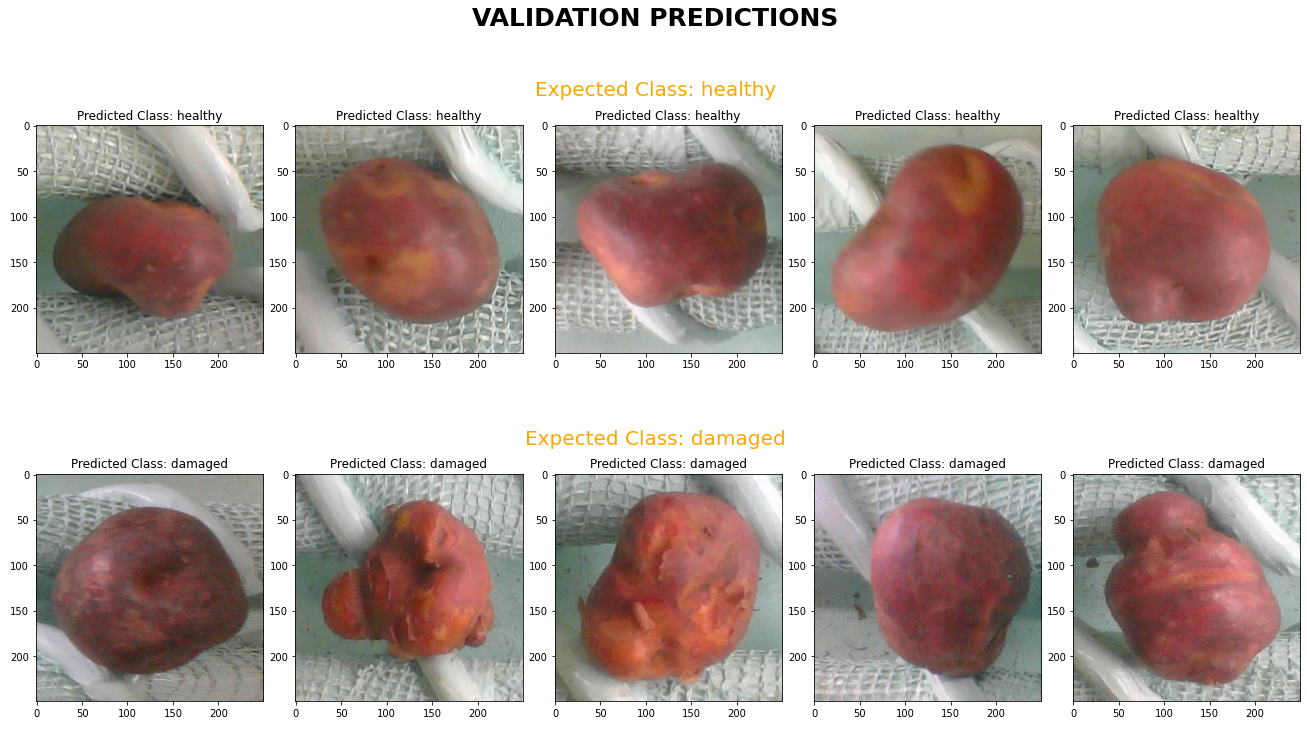

In [25]:
path_set = 'test'
validation_images = {
    'healthy': [f'./dataset/{path_set}/healthy/' + img for img in os.listdir(f'./dataset/{path_set}/healthy')],
    'damaged': [f'./dataset/{path_set}/damaged/' + img for img in os.listdir(f'./dataset/{path_set}/damaged')],
}

num_images = 5

fig, axes = plt.subplots(len(validation_images), 1, constrained_layout=True, figsize=(18,10))
for ax in axes: ax.remove()
fig.suptitle('VALIDATION PREDICTIONS', size=25, weight='bold')
gridspec = axes[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    # Random select class
    label = list(validation_images.keys())[row]
    paths = rd.sample(validation_images[label], num_images)
    # Configure row subplot
    subfig.suptitle(f'\n\nExpected Class: {label}', size=20, color='orange')
    axes = subfig.subplots(1, num_images)
    for col, ax in enumerate(axes):
        # Select image
        img = image.load_img(paths[col], target_size=(250,250))
        x = image.img_to_array(img) / 255.
        x = np.expand_dims(x, axis=0)
        pred_value = model.predict(np.vstack([x]), batch_size=1)
        pred_label = 'healthy' if pred_value[0] > 0.5 else 'damaged'
        # Show predicted image and label
        ax.set_title(f'Predicted Class: {pred_label}')
        ax.imshow(img)

## Accuracy and Loss evaluation

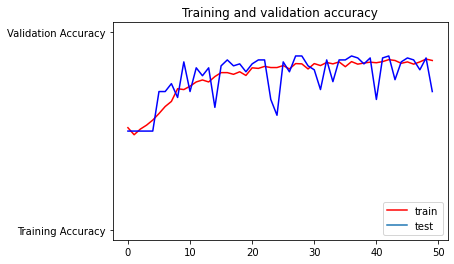

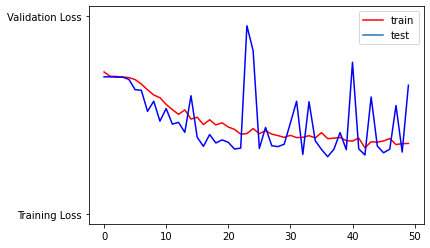

In [13]:
# Retrieve a list of list results on training and test data sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.legend(['train', 'test'])
plt.title('Training and validation accuracy')
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend(['train', 'test'])
plt.show()

## Save trained model

In [14]:
model.save_weights('./checkpoints/last_training')